In [1]:
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
DIR = "/data/NewsGuard/"
FIGURES = "/home/jluehring/newsguard/newsguard-review-paper/figures/"
TABLES = "/home/jluehring/newsguard/newsguard-review-paper/tables/"

In [3]:
# merged snapshots twice per (at the beginning and end of each month)
# see merge strategy in merge_snapshots.ipynb
# sampled only from the middle of the month
df_15 = pd.read_csv(join(DIR, "newsguard_mid_month.csv"),
                    parse_dates=["file_date"],
                    low_memory=False)
df_recent = pd.read_csv(join(DIR, "newsguard_recent_version.csv"),
                    low_memory=False)

In [4]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    sns.despine(ax=ax)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

## How many sources have a political orientation rating?

In [5]:
print(f'In the most recent database, '
      f'{df_recent["Orientation"].isnull().sum()} '
      'have no rating for orientation.\n'
      f'Out of {len(df_recent)} rows, '
      f'{df_recent["Orientation"].notnull().sum()} have a rating.\n'
      f'This is {round(df_recent["Orientation"].notnull().sum()/df_recent["Score"].notnull().sum()*100,2)}% '
      'of all ratings.')

In the most recent database, 8499 have no rating for orientation.
Out of 12288 rows, 3789 have a rating.
This is 33.39% of all ratings.


In [6]:
# exclude ALL category for further analysis
df_recent_countries = \
    df_recent[df_recent["Country"] != "ALL"]

# calculate the total number of sites per country
total_per_country = \
    df_recent_countries\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

# calculate the number of sites with orientation rating
orientation_count = \
    df_recent_countries[
        df_recent_countries["Orientation"]\
            .notnull()]\
        .groupby("Country")\
        .size()\
        .reset_index(name="Count")

# merge the two calculations 
country_counts = \
    total_per_country\
        .merge(orientation_count, 
               on="Country", 
               how="left")

# calculate the percentage of sites with orientation rating
country_counts["Percentage"] = \
    round((country_counts["Count"] / country_counts["Total"]) * 100,2)

country_counts

,Country,Total,Count,Percentage
0,AT,42,11,26.19
1,AU,166,29,17.47
2,CA,471,24,5.10
3,DE,368,62,16.85
4,FR,424,86,20.28
5,GB,568,59,10.39
6,IT,537,71,13.22
7,NZ,22,4,18.18
8,US,8281,3220,38.88


In [7]:
# count left vs right orientation ratings
orientation_countries = \
    df_recent_countries\
        .groupby("Country")["Orientation"]\
        .value_counts()\
        .unstack(fill_value=1)

# add total number of ratings per country
orientation_countries["Total"] = \
    df_recent_countries\
        .groupby("Country")["Orientation"]\
        .count()
        
# how many sites have right orientation?
orientation_countries["% right"] = \
    (orientation_countries["Right"]/orientation_countries["Total"]*100)\
        .round(2)

orientation_countries["Right"] = \
    orientation_countries["Right"].astype(str) + \
    " (" + orientation_countries["% right"].astype(str) + ")"

# how many sites have a left orientation?
orientation_countries["% left"] = \
    (orientation_countries["Left"]/orientation_countries["Total"]*100)\
        .round(2)

orientation_countries["Left"] = \
    orientation_countries["Left"].astype(str) + \
    " (" + orientation_countries["% left"].astype(str) + ")"

# drop columns
orientation_countries = \
    orientation_countries\
        .drop(["% right", "% left"], axis=1)\
        .rename(columns={"Left":"Left (%)", "Right":"Right (%)"})

# sort by Total
orientation_countries = \
    orientation_countries\
        .sort_values(by="Total", ascending=False)
orientation_countries

Orientation,Left (%),Right (%),Total
Country,,,
US,401 (12.45),2819 (87.55),3220
FR,36 (41.86),50 (58.14),86
IT,18 (25.35),53 (74.65),71
DE,10 (16.13),52 (83.87),62
GB,30 (50.85),29 (49.15),59
AU,9 (31.03),20 (68.97),29
CA,8 (33.33),16 (66.67),24
AT,2 (18.18),9 (81.82),11
NZ,1 (25.0),3 (75.0),4


In [8]:
# turn into latex table
orientation_countries_latex = \
    orientation_countries\
        .to_latex(index=True, 
                  escape=False,
                  caption="\\textbf{Orientation per country.}",
                  label="tab:orientation_countries", 
                  position='H',
                  column_format=' X c c c',
                  longtable=False, 
                  header=True, 
                  na_rep='---', 
                  bold_rows=True)

# turn into tabularx table
orientation_countries_latex = \
    orientation_countries_latex\
        .replace("\\begin{tabular}{", 
                 "\\begin{tabularx}{\\textwidth}{")
orientation_countries_latex = \
    orientation_countries_latex\
        .replace("\\end{tabular}", 
                 "\\end{tabularx}")

# add note -- replace with most recent date!
orientation_countries_latex = \
    orientation_countries_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n"
                 "\\multicolumn{5}{l}{\\textit{Note.} As of September 15h, 2024.}")

# replace all % with \%
orientation_countries_latex = \
    orientation_countries_latex\
        .replace("%", "\%")

with open(join(TABLES, 
               "orientation_countries.tex"), 
               'w') as f:
    f.write(orientation_countries_latex)

<>:35: SyntaxWarning: invalid escape sequence '\%'
<>:35: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_587467/1746694097.py:35: SyntaxWarning: invalid escape sequence '\%'
  .replace("%", "\%")


## What's the distribution in each country over time?

In [9]:
orientation_palette = {"Far Left": "#4393c3", 
                       "Slightly Left": "#92c5de",
                       "Slightly Right": "#f4a582",
                       "Far Right": "#d6604d", 
                       "Left": "#2166ac", 
                       "Right": "#b2182b"}

orientation_order = ["Far Left", "Slightly Left", 
                     "Slightly Right", "Far Right", 
                     "Left", "Right"]

In [10]:
df_15["file_year"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("Y")

df_15["file_month"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("M")

df_15_countries = df_15[
    df_15["Country"] != "ALL"]

In [11]:
# df_15_countries["Orientation"] = \
#     pd.Categorical(df_15_countries["Orientation"], 
#                    categories=orientation_order, 
#                    ordered=True)

In [12]:
# copy the orientation column
df_15_countries["Orientation_before"] = df_15_countries["Orientation"].astype(str)
df_15_countries["Orientation_after"] = df_15_countries["Orientation"].astype(str)

# recode Left and Right in Orientation to NaN
df_15_countries["Orientation_before"] = \
    df_15_countries["Orientation_before"]\
        .replace({"Left": np.nan, 
                  "Right": np.nan})

# recode more granular rating to NaN
df_15_countries["Orientation_after"] = \
    df_15_countries["Orientation_after"]\
        .replace({"Far Left": np.nan,
                  "Slightly Left": np.nan,
                  "Far Right": np.nan,
                  "Slightly Right": np.nan})

In [13]:
# count the ratings per country, month, and year
orientation_before = df_15_countries\
        .groupby(["Country", "file_month", "file_year"])["Orientation_before"] \
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

# reshape 
orientation_before = \
    orientation_before \
        .melt(id_vars=["Country", "file_month", "file_year"], 
            value_vars=["Far Left", "Far Right", "Slightly Left", "Slightly Right"], 
            var_name="Orientation_before", 
            value_name="Count_before")

# aggregate the number of ratings per year
orientation_year_before = orientation_before\
    .groupby(["Country", "file_year", "Orientation_before"])["Count_before"]\
    .agg("mean")\
    .reset_index()

# count the ratings per country, month, and year for after the change
orientation_after = \
    df_15_countries\
        .groupby(["Country", "file_month", "file_year"])["Orientation_after"]\
        .value_counts(normalize=False)\
        .unstack()\
        .fillna(0)\
        .reset_index()

orientation_after = \
 orientation_after\
    .melt(id_vars=["Country", "file_month", "file_year"], 
          value_vars=["Left", "Right"], 
          var_name="Orientation_after", 
          value_name="Count_after")

#calculate average per year
orientation_year_after = orientation_after\
    .groupby(["Country", "file_year", "Orientation_after"])["Count_after"]\
    .agg("mean")\
    .reset_index()

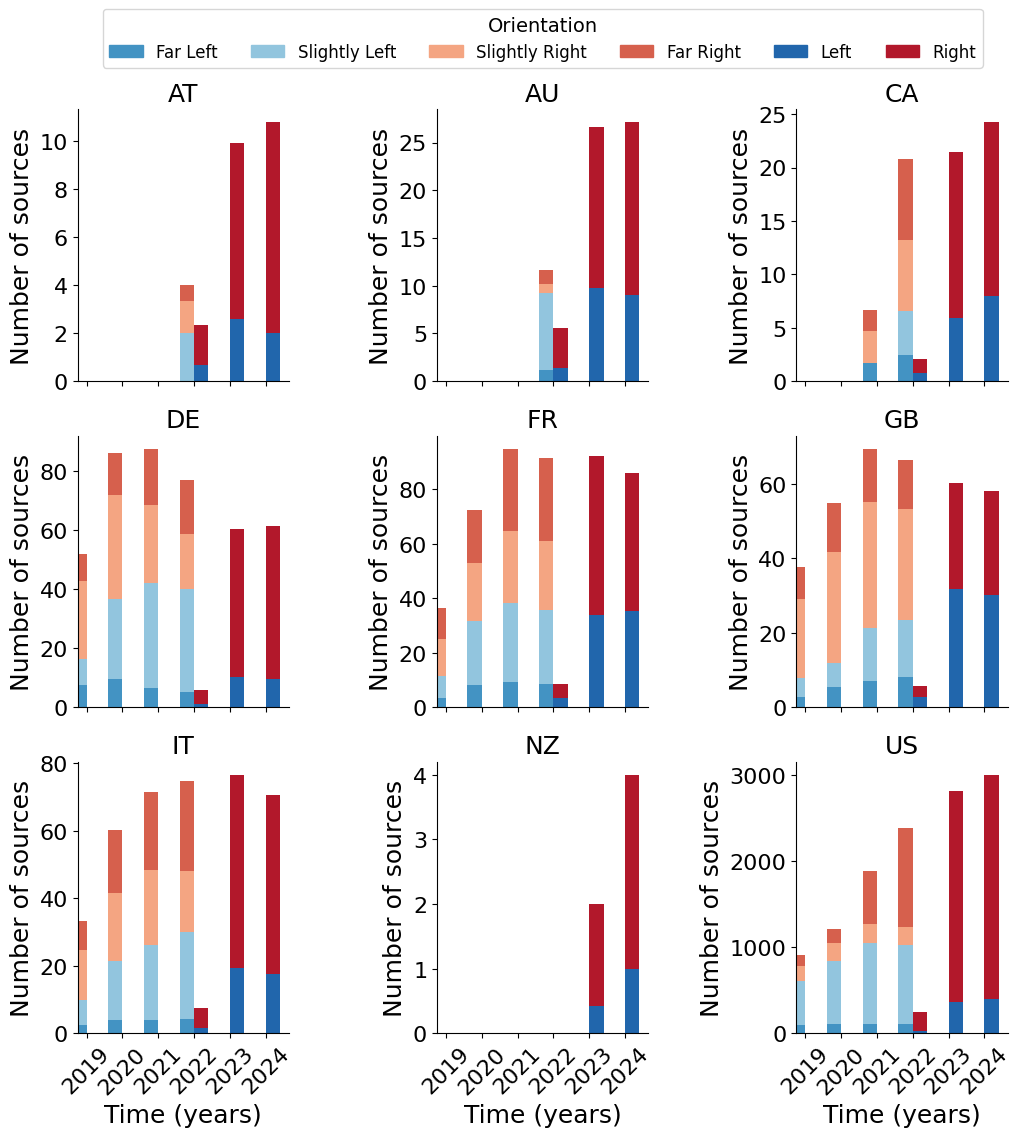

In [14]:
#plot with two variables on the y-axis
fig, axs = plt.subplots(nrows=3, ncols=3, 
                        figsize=(12, 12), 
                        sharey=False, 
                        sharex=True)

plt.subplots_adjust(hspace=0.2, 
                    wspace=0.7)

orientation_palette_before = {
                        "Far Left": "#4393c3", 
                        "Slightly Left": "#92c5de",
                        "Slightly Right": "#f4a582",
                        "Far Right": "#d6604d"}
 
orientation_palette_after = {"Left": "#2166ac",
                             "Right": "#b2182b"}


unique_years = sorted(orientation_year_after["file_year"].unique())

for i, country in enumerate(orientation_year_before["Country"].unique()):
    row = i // 3
    col_in_row = i % 3

    orientation_year_country_before = orientation_year_before[orientation_year_before["Country"] == country]
    orientation_counts_before = orientation_year_country_before.pivot(index="file_year",
                                                                      columns="Orientation_before",
                                                                      values="Count_before")
    orientation_counts_before = orientation_counts_before.reindex(unique_years, fill_value=0)
    orientation_counts_before.plot(kind="bar",
                                   stacked=True,
                                   ax=axs[row, col_in_row],
                                   width=0.4,
                                   position=1,
                                   legend=False,
                                   color=orientation_palette_before.values())


    orientation_year_country_after = orientation_year_after[orientation_year_after["Country"] == country]
    orientation_counts_after = orientation_year_country_after.pivot(index="file_year",
                                                                    columns="Orientation_after",
                                                                    values="Count_after")
    orientation_counts_after = orientation_counts_after.reindex(unique_years, fill_value=0)
    orientation_counts_after.plot(kind="bar",
                                  stacked=True,
                                  ax=axs[row, col_in_row],
                                  width=0.4,
                                  position=0,
                                  legend=False,
                                  color=orientation_palette_after.values())

    axs[row, col_in_row].set_xlabel("Time (years)", fontsize=18)
    axs[row, col_in_row].set_ylabel("Number of sources", fontsize=18)
    axs[row, col_in_row].set_title(f"{country}", fontsize=18)
    axs[row, col_in_row].tick_params(axis="x", labelsize=16, rotation=45)
    axs[row, col_in_row].tick_params(axis="y", labelsize=16)
    custom_plots(ax=axs[row, col_in_row])

# add shared legend
handles = [mpatches.Patch(color=color, label=label) 
           for label, color in orientation_palette_before.items()]
handles += [mpatches.Patch(color=color, label=label) 
            for label, color in orientation_palette_after.items()]

axs[2, 2].legend(handles=handles, 
                 title="Orientation", 
                 loc="upper center", 
                 bbox_to_anchor=(-1.2, 3.8), 
                 ncol=6, 
                 title_fontsize=14,
                 fontsize=12)


plt.savefig(join(FIGURES, "orientation_over_time_per_country_before_after.pdf"),
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

In [15]:
# collapse the ratings into binary categories
for df in [df_15, df_15_countries]:
    df["Orientation_binary"] = df["Orientation"]\
        .replace(
        {"Far Left": "Left", "Slightly Left": "Left", 
         "Slightly Right": "Right", 
         "Far Right": "Right"})

left_right_count = df_15_countries["Orientation_binary"]\
    .value_counts()\
    .reset_index()

left_right_count["%"] = \
    ((left_right_count["count"] / left_right_count["count"].sum()) * 100) \
        .round(2)

left_right_count

,Orientation_binary,count,%
0,Right,125322,80.43
1,Left,30496,19.57


## How trustworthy are left vs right sources?

In [16]:
df_recent\
    .groupby("Orientation")["Score"]\
    .describe()

,count,mean,std,min,25%,50%,75%,max
Orientation,,,,,,,,
Left,573.0,60.612565,26.062877,7.5,39.5,62.5,82.5,100.0
Right,3200.0,26.434062,20.342965,0.0,7.5,32.0,32.0,100.0


In [17]:
# calculate the difference in means
left_mean = df_recent[df_recent["Orientation"] == "Left"]["Score"].mean()
right_mean = df_recent[df_recent["Orientation"] == "Right"]["Score"].mean()

diff = right_mean - left_mean
diff

-34.17850294502618

In [18]:
ttest_recent = \
    stats\
        .ttest_ind(
            df_recent[df_recent["Orientation"] == "Left"]["Score"], 
            df_recent[df_recent["Orientation"] == "Right"]["Score"],
            nan_policy="omit")

ttest_recent

TtestResult(statistic=35.35792387246477, pvalue=9.000642697392159e-237, df=3771.0)

In [19]:
score_x_orientation_time = df_15_countries\
    .groupby(["file_month", "Orientation"])["Score"]\
    .agg(["mean", "std"])

score_x_orientation_time\
    .loc["2021-06":"2021-09"]

mean        std
file_month Orientation                         
2021-06    Far Left        52.944853  26.852869
           Far Right       15.197780  20.723242
           Slightly Left   81.012195  18.711388
           Slightly Right  61.667247  29.175618
2021-07    Far Left        53.175182  26.908928
           Far Right       15.123232  20.666326
           Slightly Left   80.826347  18.805662
           Slightly Right  61.790102  29.137801
2021-08    Far Left        53.434307  26.898695
           Far Right       14.525919  19.647016
           Slightly Left   80.735207  18.739432
           Slightly Right  38.980952  18.887465
2021-09    Far Left        53.371429  26.639437
           Far Right       14.423186  19.574495
           Slightly Left   80.753644  18.656908
           Slightly Right  39.070751  18.940027

### How trustworthy are political sources per country? 

In [20]:
# country average score per orientation over time
score_x_orientation_time_country = df_15_countries\
    .groupby(["Country", "file_month", "Orientation_binary"])["Score"]\
    .agg(['mean', 'std'])\
    .reset_index()
score_x_orientation_time_country.head()

,Country,file_month,Orientation_binary,mean,std
0,AT,2022-10,Left,97.50,3.535534
1,AT,2022-10,Right,8.75,2.500000
2,AT,2022-11,Left,97.50,3.535534
3,AT,2022-11,Right,8.75,2.500000
4,AT,2022-12,Left,97.50,3.535534


In [21]:
score_x_orientation = df_recent_countries\
    .groupby(["Country", "Orientation"])["Score"]\
    .agg(["mean", "std"])\
    .reset_index()

score_x_orientation_sizes = df_recent_countries\
    .groupby(["Country", "Orientation"])\
    .size()\
    .reset_index(name="size")

score_x_orientation = \
    score_x_orientation.merge(score_x_orientation_sizes, 
    on=["Country", "Orientation"])

score_x_orientation

,Country,Orientation,mean,std,size
0,AT,Left,88.750000,8.838835,2
1,AT,Right,37.166667,37.857463,9
2,AU,Left,78.333333,13.520817,9
3,AU,Right,17.675000,16.379765,20
4,CA,Left,88.125000,28.870091,8
5,CA,Right,59.312500,28.012423,16
6,DE,Left,84.700000,14.271572,10
7,DE,Right,31.596154,25.693716,52
8,FR,Left,53.458333,32.606830,36
9,FR,Right,27.320000,23.111478,50


In [22]:
#add to score_x_orientation
score_x_orientation = \
    score_x_orientation.merge(
        country_counts,
        on="Country"
    )

# rename columns
score_x_orientation = \
    score_x_orientation\
        .rename(columns={"mean":"Mean", 
                         "std":"SD",
                         "size":"n_per_orientation",
                         "Total": "n_total_sources",
                         "Count":"n_rated_sources",
                         "Percentage":"perc_rated_sources"})

score_x_orientation

,Country,Orientation,Mean,SD,n_per_orientation,n_total_sources,n_rated_sources,perc_rated_sources
0,AT,Left,88.750000,8.838835,2,42,11,26.19
1,AT,Right,37.166667,37.857463,9,42,11,26.19
2,AU,Left,78.333333,13.520817,9,166,29,17.47
3,AU,Right,17.675000,16.379765,20,166,29,17.47
4,CA,Left,88.125000,28.870091,8,471,24,5.10
5,CA,Right,59.312500,28.012423,16,471,24,5.10
6,DE,Left,84.700000,14.271572,10,368,62,16.85
7,DE,Right,31.596154,25.693716,52,368,62,16.85
8,FR,Left,53.458333,32.606830,36,424,86,20.28
9,FR,Right,27.320000,23.111478,50,424,86,20.28


In [23]:
#standardize size by total number of sources per country
score_x_orientation["perc_per_orientation"] = \
    round(score_x_orientation["n_per_orientation"] / score_x_orientation["n_total_sources"] * 100, 2)
score_x_orientation

,Country,Orientation,Mean,SD,n_per_orientation,n_total_sources,n_rated_sources,perc_rated_sources,perc_per_orientation
0,AT,Left,88.750000,8.838835,2,42,11,26.19,4.76
1,AT,Right,37.166667,37.857463,9,42,11,26.19,21.43
2,AU,Left,78.333333,13.520817,9,166,29,17.47,5.42
3,AU,Right,17.675000,16.379765,20,166,29,17.47,12.05
4,CA,Left,88.125000,28.870091,8,471,24,5.10,1.70
5,CA,Right,59.312500,28.012423,16,471,24,5.10,3.40
6,DE,Left,84.700000,14.271572,10,368,62,16.85,2.72
7,DE,Right,31.596154,25.693716,52,368,62,16.85,14.13
8,FR,Left,53.458333,32.606830,36,424,86,20.28,8.49
9,FR,Right,27.320000,23.111478,50,424,86,20.28,11.79


## Figure 3

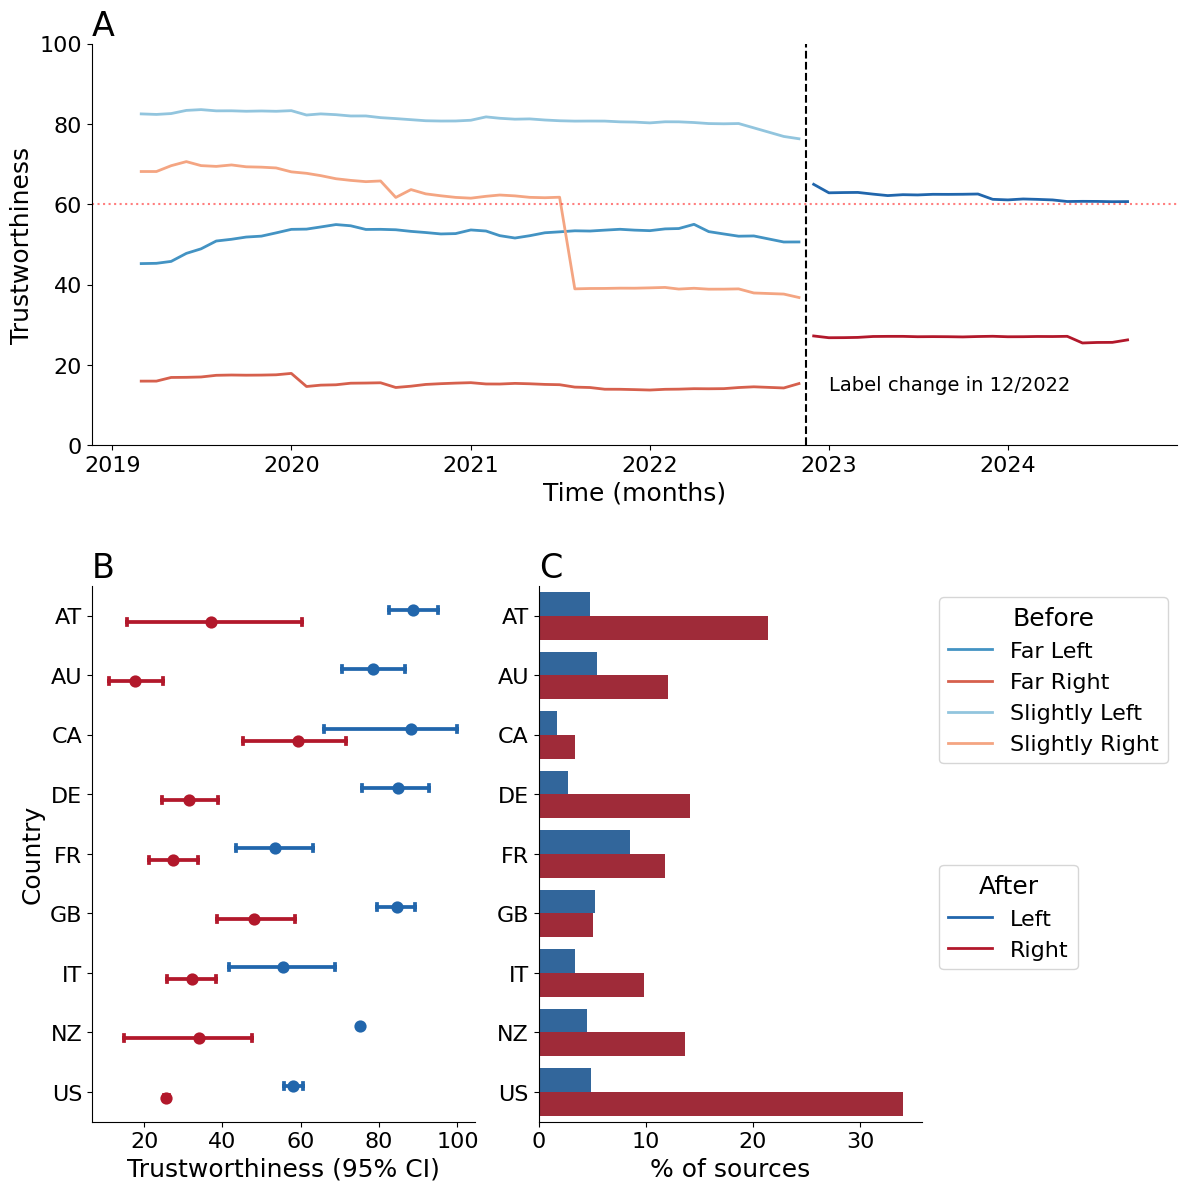

In [24]:
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(2, 3,
              width_ratios=[1, 1, 0.5],
              height_ratios=[0.75, 1],
              hspace=0.3)  

""" SUBPLOT A """
ax0 = fig.add_subplot(gs[0, :])

score_x_orientation_time = score_x_orientation_time\
    .reset_index()

score_x_orientation_time["file_month"] = \
    score_x_orientation_time["file_month"].dt.to_timestamp()

sns.lineplot(data=score_x_orientation_time,
             x="file_month",
             y="mean",
             hue="Orientation",
             linewidth=2,
             palette=orientation_palette, 
             ax=ax0)

ax0.set_xlabel("Time (months)", fontsize=18)
ax0.set_ylabel("Trustworthiness", fontsize=18)
ax0.set_title("A", fontsize=24, loc="left")
custom_plots(ax=ax0)
ax0.tick_params(axis="both", 
                labelsize=16, 
                rotation=0)
ax0.set_ylim(0,100)

ax0.text(x=pd.Timestamp("2023-01-01"),
         y=15,
         s="Label change in 12/2022", 
         fontsize=14, 
         color="black",
         alpha=1, 
         verticalalignment="center", 
         bbox=dict(facecolor="none", 
                   edgecolor="none",
                   #boxstyle="round,pad=0.3", 
                   alpha=0.5))

#add a vertical line 
ax0.axvline(x=pd.Timestamp("2022-11-15"),
            color="black",
            linestyle="dashed",
            alpha=1)

ax0.axhline(y=60,
            color="red",
            linestyle="dotted",
            alpha=0.5)

ax0.legend().remove()

""" SUBPLOT B """
ax1 = fig.add_subplot(gs[1,0])
ax1.set_title("B", fontsize=24, loc="left")

country_diff = df_recent[df_recent["Country"] != "ALL"]

sns.pointplot(
    data=country_diff, 
    y="Country", 
    x="Score", 
    hue="Orientation", 
    capsize=0.1,
    order=sorted(country_diff["Country"].unique()),
    errorbar=("ci",95),
    palette=orientation_palette_after,
    linestyle="none",
    dodge=0.2,
    ax=ax1)

ax1.set_xlabel("Trustworthiness (95% CI)",
                fontsize=18)
ax1.set_ylabel("Country", fontsize=18)
ax1.legend().remove()
ax1.tick_params(axis="both", 
                labelsize=16, 
                rotation=0)
custom_plots(ax=ax1)

#add a count plot with dodged bars for each country and the size
ax2 = fig.add_subplot(gs[1,1])
sns.barplot(data=score_x_orientation, 
            x="perc_per_orientation", 
            y="Country", 
            hue="Orientation", 
            order=sorted(score_x_orientation["Country"].unique()),
            palette=orientation_palette_after,
            dodge=True,
            ax=ax2)

ax2.set_ylabel("")
ax2.set_xlabel("% of sources", fontsize=18)
ax2.tick_params(axis="both", labelsize=16)
ax2.legend().remove()
ax2.set_title("C", fontsize=24, loc="left")
custom_plots(ax=ax2)

""" LEGENDS """
ax3a = fig.add_subplot(gs[1, 2])
ax3a.plot([], [])

handles, labels = ax0.get_legend_handles_labels()
first_legend_indices = [0,1,2,3] 
second_legend_indices = [4,5]  

first_legend_handles = [handles[i] for i in first_legend_indices]
first_legend_labels = [labels[i] for i in first_legend_indices]

ax3a.legend(first_legend_handles, first_legend_labels,
            title="Before",
            title_fontsize=18,
            loc="upper left",
            bbox_to_anchor=(-0.3, 1),
            fontsize=16)
ax3a.set_xticks([])
ax3a.set_yticks([])
ax3a.set_xticklabels([])
ax3a.set_yticklabels([])
ax3a.patch.set_alpha(0)
ax3a.set_facecolor("none")
ax3a.axis("off")

ax3b = fig.add_subplot(gs[1, 2])  
ax3b.plot([], [])  
second_legend_handles = [handles[i] for i in second_legend_indices]
second_legend_labels = [labels[i] for i in second_legend_indices]
ax3b.legend(second_legend_handles, second_legend_labels,
            title="After",
            title_fontsize=18,
            loc="upper left",
            bbox_to_anchor=(-0.3, 0.5), 
            fontsize=16)
ax3b.set_xticks([])
ax3b.set_yticks([])
ax3b.set_xticklabels([])
ax3b.set_yticklabels([])
ax3b.patch.set_alpha(0)
ax3b.set_facecolor("none")
ax3b.axis("off")

plt.savefig(join(FIGURES,
                    "orientation_panel.pdf"),
            bbox_inches="tight", 
            pad_inches=0.1,
            dpi=300)
plt.show()

## Can we validate the ratings?

In [25]:
df_15_de = df_15[df_15["Language"] == "de"]

#only until june 15
df_15_de_val = df_15_de[df_15_de["file_month"] <= "2024-09"]

df_15_de_val = df_15_de_val\
    .drop_duplicates(
        subset="Domain", 
        keep="last")

print(f'Validating {len(df_15_de_val)} domains as of {df_15_de_val.file_month.max()}')
df_15_de_val = df_15_de_val[["Domain", "Orientation_binary"]]
#df_15_de_val.to_csv("df_15_de_orientation.csv", index=False)

Validating 426 domains as of 2024-09


In [26]:
df_15_de_manual = pd.read_csv("../df_15_de_orientation_annotated.csv", 
                                  delimiter=";")

df_15_de_overlap = df_15_de_val.merge(df_15_de_manual, 
                                  on="Domain", 
                                  how="left")

df_15_de_overlap["Orientation_manual"]\
    .value_counts()

Orientation_manual
Right    92
Left     30
Dead     20
Name: count, dtype: int64

In [27]:
df_15_de_overlap = df_15_de_overlap[
    df_15_de_overlap["Orientation_manual"] != "Dead"]
len(df_15_de_overlap)

406

In [28]:
print(f'Manual: ')
print(f'{df_15_de_overlap["Orientation_manual"].value_counts(normalize=True)}')

print(f'NewsGuard: ')
print(f'{df_15_de_overlap["Orientation_binary"].value_counts(normalize=True)}')

Manual: 
Orientation_manual
Right    0.754098
Left     0.245902
Name: proportion, dtype: float64
NewsGuard: 
Orientation_binary
Right    0.819444
Left     0.180556
Name: proportion, dtype: float64


In [29]:
both_present = df_15_de_overlap[
    (df_15_de_overlap['Orientation_manual'].notnull()) & 
    (df_15_de_overlap['Orientation_binary'].notnull())
]
only_manual = df_15_de_overlap[
    (df_15_de_overlap['Orientation_manual'].notnull()) & 
    (df_15_de_overlap['Orientation_binary'].isnull())
]

only_ng = df_15_de_overlap[
    (df_15_de_overlap['Orientation_binary'].notnull()) & 
    (df_15_de_overlap['Orientation_manual'].isnull())
]

print(f'Both present: {len(both_present)}')
print(f'Only manual: {len(only_manual)}')
print(f'Only NG: {len(only_ng)}')

Both present: 64
Only manual: 58
Only NG: 8


In [30]:
df_15_de_overlap["Agreement"] = (
    df_15_de_overlap["Orientation_binary"].astype('string').fillna('NaN') ==
    df_15_de_overlap["Orientation_manual"].astype('string').fillna('NaN')
)
df_15_de_overlap["Agreement"] = \
    df_15_de_overlap["Agreement"]\
        .astype(int)

print(f'Agreement manual vs NG: {df_15_de_overlap["Agreement"].mean().round(2)}')

Agreement manual vs NG: 0.83


In [31]:
#look at the ones with no agreement
#df_15_de_overlap[df_15_de_overlap["Agreement"] == 0]

In [32]:
#df_15_de_overlap[(df_15_de_overlap["Orientation_binary"].isna()) &
#                 (df_15_de_overlap["Orientation_manual"] == "Left") & 
#                 ((df_15_de_overlap["MBFC"] == "LEFT-CENTER") | 
#                  (df_15_de_overlap["MBFC"] == "LEFT"))]

In [33]:
#recode everything containing LEFT in MBFC to Left
df_15_de_overlap["MBFC_binary"] = df_15_de_overlap["MBFC"]\
    .replace({"LEFT-CENTER": "Left", "LEFT": "Left",
              "RIGHT-CENTER": "Right", "RIGHT": "Right",
              "RIGHT-CONSPIRACY": "Right",
              "RIGHT CONSPIRACY-PSEUDOSCIENCE": "Right",
              "LEAST BIASED": None})

print(f'Number of labels in MBFC: {df_15_de_overlap["MBFC_binary"].notnull().sum()}')

Number of labels in MBFC: 41


In [34]:
expert_present = df_15_de_overlap[
    (df_15_de_overlap['MBFC_binary'].notnull()) & 
    (df_15_de_overlap['Orientation_binary'].notnull())
]
mbfc_present = df_15_de_overlap[
    (df_15_de_overlap['MBFC_binary'].notnull()) & 
    (df_15_de_overlap['Orientation_binary'].isnull())
]

ng_present = df_15_de_overlap[
    (df_15_de_overlap['MBFC_binary'].isnull()) & 
    (df_15_de_overlap['Orientation_binary'].notnull())
]

print(f'Both expert ratings: {len(expert_present)}')
print(f'Only MBFC: {len(mbfc_present)}')
print(f'Only NG: {len(ng_present)}')

Both expert ratings: 6
Only MBFC: 35
Only NG: 66


In [35]:
#agreement in expert_present
expert_present["Agreement_experts"] = (
    expert_present["MBFC_binary"] == expert_present["Orientation_binary"]
)
expert_present["Agreement_experts"] = \
    expert_present["Agreement_experts"]\
        .astype(int)
print(f'Agreement: {expert_present["Agreement_experts"].mean().round(2)}')
# expert_present[expert_present["Agreement_experts"] == 0]
# only one case where they differ

Agreement: 0.83


In [36]:
#merge MBFC and manual into a new column
df_15_de_overlap["Orientation_merged"] = \
    df_15_de_overlap["MBFC_binary"]\
        .combine_first(df_15_de_overlap["Orientation_binary"])

#calculate agreement
df_15_de_overlap["Agreement_merged"] = (
    df_15_de_overlap["Orientation_manual"].astype("string").fillna("NaN") ==
    df_15_de_overlap["Orientation_merged"].astype("string").fillna("NaN")
)
df_15_de_overlap["Agreement_merged"] = \
    df_15_de_overlap["Agreement_merged"]\
        .astype(int)

perc_merged = df_15_de_overlap["Agreement_merged"].mean().round(2)

print(f'Agreement when merging NG with MBFC: {perc_merged}')

Agreement when merging NG with MBFC: 0.9


In [37]:
# df_15_de_overlap[df_15_de_overlap["Agreement_merged"] == 0]

In [38]:
# merge the ratings
df_15_de_overlap["Orientation_all"] = \
    df_15_de_overlap["Orientation_manual"]\
        .combine_first(df_15_de_overlap["Orientation_merged"])

df_15_de_overlap["Orientation_all"].value_counts()

Orientation_all
Right    99
Left     35
Name: count, dtype: int64

In [39]:
df_15_de_overlap["Orientation_all"] = \
    df_15_de_overlap["Orientation_all"].fillna("Neutral")

df_15_de_overlap["Orientation_all"].value_counts()

Orientation_all
Neutral    272
Right       99
Left        35
Name: count, dtype: int64

In [40]:
#save as csv
df_15_de_overlap.to_csv("df_15_de_orientation_validated.csv", index=False)

### Have domains ever switched their labels?

In [41]:
# have domains changed their rating?
domains_changed = df_15_countries[["Domain", "file_month", "Orientation", "Country"]]\
    .groupby("Domain").filter(lambda x: x["Orientation"].nunique() > 1)

# now keep only specific timeframe in file_date
domains_changed = domains_changed[
    (domains_changed['file_month'] == "2022-11") | (domains_changed['file_month'] == "2022-12")]

# drop duplicated rows
domains_changed = domains_changed\
    .drop_duplicates(
        subset=["Domain", 
                "file_month", 
                "Country",
                "Orientation"], 
        keep="last")

# sort by domain and date
# to see domains that have changed
domains_changed = domains_changed\
    .sort_values(["Domain", "file_month"])

# count the number of changes per domain
domain_changes_no = domains_changed\
    .groupby("Domain")\
    .size()\
    .reset_index(name="Changes")

# extract the name of the domain that has changed the most
most_volatile_domain = domain_changes_no[
    domain_changes_no["Changes"] == domain_changes_no["Changes"]\
        .max()]["Domain"].values[0]

# domains_changed[domains_changed["Domain"] == most_volatile_domain]

In [42]:
# changes in collapsed ratings
df_15_Orientation_diff = \
    df_15_countries[["Domain", 
                     "file_month", 
                     "Score",
                     "Country", 
                     "Orientation_binary"]]

# convert into numerical value
df_15_Orientation_diff["Orientation_binary"] = \
    df_15_Orientation_diff["Orientation_binary"]\
        .replace({"Left": 0, 
                  "Right": 1})\
        .astype(float)

df_15_Orientation_diff.sort_values(by=["Domain", "Country", "file_month"], 
                                   inplace=True)

df_15_Orientation_diff["Orientation_diff"] = df_15_Orientation_diff\
        .groupby(["Domain", "Country"])["Orientation_binary"]\
        .diff()

df_15_Orientation_diff["Score_diff"] = df_15_Orientation_diff\
        .groupby(["Domain", "Country"])["Score"]\
        .diff()

df_15_Orientation_diff_filtered = \
        df_15_Orientation_diff[
                df_15_Orientation_diff["Orientation_diff"].notnull() 
                & (df_15_Orientation_diff["Orientation_diff"] != 0)]

df_15_Orientation_diff_filtered["Orientation_diff"].value_counts()

/tmp/ipykernel_587467/1687827933.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Left": 0,


Orientation_diff
1.0    4
Name: count, dtype: int64

In [43]:
#df_15_Orientation_diff[df_15_Orientation_diff["Domain"] == "newsblaze.com"].head(20)